[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aangelopoulos/conformal-prediction/blob/main/notebooks/meps-uncertainty-scalar.ipynb)

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

In [2]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')
    
data = np.load('../data/meps/meps-gbr.npz')
X, labels, upper, lower, pred = data['X'], data['y'], data['upper'], data['lower'], data['pred']

In [3]:
# Problem setup
n=1000 # number of calibration points
alpha = 0.1 # 1-alpha is the desired coverage

In [4]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (labels.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_labels, val_labels = labels[idx], labels[~idx]
cal_upper, val_upper = upper[idx], upper[~idx]
cal_lower, val_lower = lower[idx], lower[~idx]
cal_pred, val_pred = pred[idx], pred[~idx]
val_X = X[~idx]

In [5]:
# We'll choose the uncertainty scalar to be the difference between quantiles, for simplicity
cal_U = cal_upper - cal_lower
val_U = val_upper - val_lower

### Conformal prediction happens here

In [6]:
# Get scores
cal_scores = np.abs(cal_pred-cal_labels)/cal_U
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')
# Deploy (output=lower and upper adjusted quantiles)
prediction_sets = [val_pred - val_U*qhat, val_pred + val_U*qhat ]

In [7]:
# Calculate empirical coverage (before and after calibration)
prediction_sets_uncalibrated = [val_lower, val_upper]
empirical_coverage_uncalibrated = ((val_labels >= prediction_sets_uncalibrated[0]) & (val_labels <= prediction_sets_uncalibrated[1])).mean()
print(f"The empirical coverage before calibration is: {empirical_coverage_uncalibrated}")
empirical_coverage = ((val_labels >= prediction_sets[0]) & (val_labels <= prediction_sets[1])).mean()
print(f"The empirical coverage after calibration is: {empirical_coverage}")

The empirical coverage before calibration is: 0.739735964021471
The empirical coverage after calibration is: 0.8951109821558102


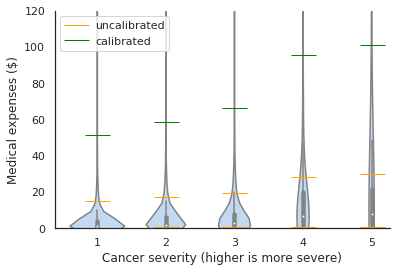

In [8]:
# Plot results stratifying across cancer severity (one of many covariates)
cancer_vecs = val_X[:,40:45]
for col in range(cancer_vecs.shape[1]):
    one_val = cancer_vecs[:,col].max()
    cancer_vecs[:,col] = (cancer_vecs[:,col] == one_val).astype(int)
cancer_dx = cancer_vecs.dot(np.arange(5)+1).astype(int)

# Trim missing labels
val_labels_trimmed = val_labels[cancer_dx > 0]
val_lower_trimmed = val_lower[cancer_dx > 0]
val_upper_trimmed = val_upper[cancer_dx > 0]
cancer_dx_trimmed = cancer_dx[cancer_dx > 0]
valid_cancer_dx = np.arange(5)+1

lower_uncal = [(np.e**(val_lower_trimmed[cancer_dx_trimmed == dx]) - 1).mean() for dx in valid_cancer_dx]
lower_cal = [(np.e**(val_lower_trimmed[cancer_dx_trimmed == dx]-qhat) - 1).mean() for dx in valid_cancer_dx]
upper_uncal = [(np.e**(val_upper_trimmed[cancer_dx_trimmed == dx]) - 1).mean() for dx in valid_cancer_dx]
upper_cal = [(np.e**(val_upper_trimmed[cancer_dx_trimmed == dx]+qhat) - 1).mean() for dx in valid_cancer_dx]

sns.set(style='white')
sns.set_palette('pastel')
plt.figure()
plt_idx = np.random.choice(np.arange(val_labels_trimmed.shape[0]), size=(val_labels_trimmed.shape[0],), replace=False)
sns.violinplot(x=cancer_dx_trimmed[plt_idx], y=np.e**val_labels_trimmed[plt_idx]-1, color='#BBD9FA')
plt.plot(valid_cancer_dx-1, lower_uncal, marker='_', markersize='25', linewidth=0, color='orange', label='uncalibrated')
plt.plot(valid_cancer_dx-1, upper_uncal, marker='_', markersize='25', linewidth=0, color='orange')
plt.plot(valid_cancer_dx-1, lower_cal, marker='_', markersize='25', linewidth=0, color='green', label='calibrated')
plt.plot(valid_cancer_dx-1, upper_cal, marker='_', markersize='25', linewidth=0, color='green')
plt.legend(loc='upper left')
plt.ylim(0,120)
plt.xlabel('Cancer severity (higher is more severe)')
plt.ylabel('Medical expenses ($)')
sns.despine(top=True,right=True)
plt.show()